# Libraries

In [7]:
import csv
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.tv_tensors as tv_tensors
from torchvision.transforms import v2
from sklearn.preprocessing import MultiLabelBinarizer
import timm
import torchmetrics
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import time
import pandas as pd
import random
import string
import itertools
from collections import Counter
from tqdm import tqdm

# Preprocessing

Processing train CSV...
Read 30000 rows from train.csv
Problematic rows found: 4
Line 9086: ['9084.jpg', '3 1 11', 'A street sign labeled Seltzer Way', ' with a red fire hydrant in the foreground and a street stretching into the background.'] | Reason: Fixed field count (was 4)
Line 9510: ['9508.jpg', '1', 'A cow in street with writing that reads oh no', ' not beef on the menu again!""'] | Reason: Fixed field count (was 4)
Line 18114: ['18112.jpg', '1', 'A small hand is forming thethumbs up', ' signal.'] | Reason: Fixed field count (was 4)
Line 27169: ['27167.jpg', '10', 'A street sign that says Sex St', ' along with a sign saying there is a $350 penalty is you honk.'] | Reason: Fixed field count (was 4)
Cleaned data written to train_cleaned.csv
train_cleaned.csv shape: 30000 rows, 3 columns
Columns: ['ImageID', 'Labels', 'Caption']
Processing test CSV...
Read 10000 rows from test.csv
Problematic rows found: 2
Line 9086: ['39084.jpg', 'A group of people flying kites while standing in t

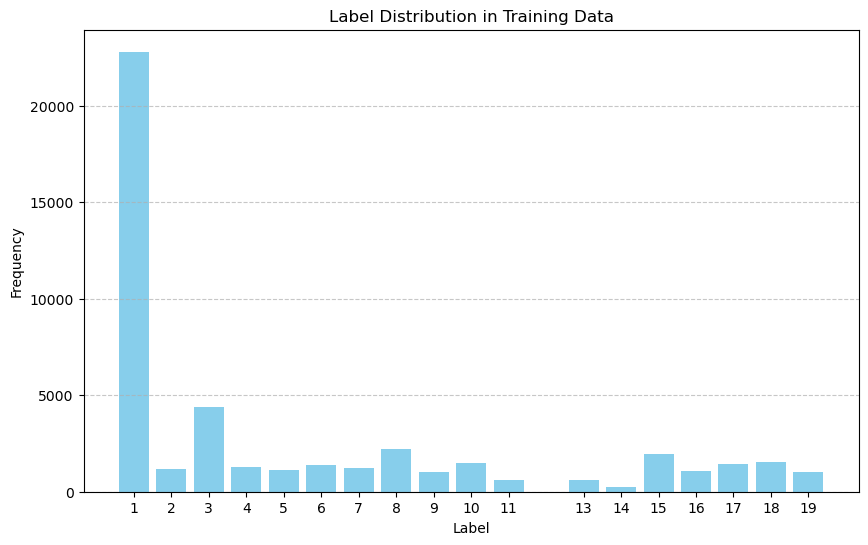

Image ID: 0.jpg
Caption: Woman in swim suit holding parasol on sunny day.
Labels: 1


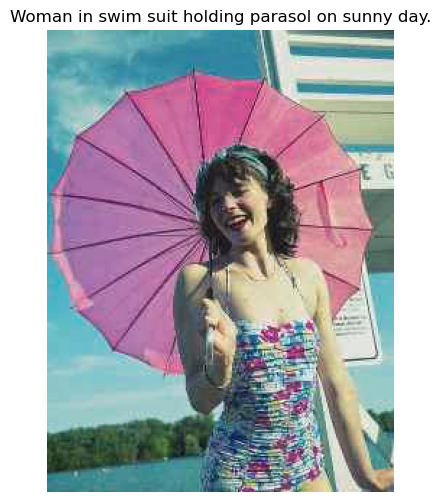

In [8]:
def set_seed(seed: int) -> None:
    """Set random seed for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_device() -> torch.device:
    """Return the best available device (CUDA, MPS, or CPU)."""
    if torch.cuda.is_available():
        return torch.device("cuda")
    if torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device("mps")
    print("MPS and CUDA not available, falling back to CPU")
    return torch.device("cpu")

def get_model_size(model, model_name: str = "Model") -> tuple[int, float]:
    """Calculate model size in MB."""
    total_params = sum(p.numel() for p in model.parameters())
    size_mb = total_params * 4 / (1024 * 1024)
    print(f"{model_name} - Total Parameters: {total_params:,}, Size: {size_mb:.2f} MB")
    return total_params, size_mb

def get_file_size(file_path: str) -> float:
    """Get file size in MB."""
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return 0
    size_mb = os.path.getsize(file_path) / (1024 * 1024)
    print(f"File {file_path} - Size: {size_mb:.2f} MB")
    return size_mb

# Caption Encoding
alphabet_combinations = {'1': string.ascii_lowercase, '2': string.ascii_lowercase}
alphabet_mapping = {''.join(combo): i for i, combo in enumerate(itertools.product(*[alphabet_combinations[k] for k in sorted(alphabet_combinations.keys())]))}

def encode_captions(captions: list) -> torch.Tensor:
    """Encode captions into feature vectors."""
    word_encoding_array = np.zeros((len(captions), len(alphabet_mapping)), dtype=np.float32)
    for caption_num, caption in enumerate(captions):
        split_text = [x for x in caption.lower() if x in string.ascii_lowercase]
        for idx in range(len(split_text) - 1):
            combination = ''.join(split_text[idx:idx + 2])
            if combination in alphabet_mapping:
                word_encoding_array[caption_num][alphabet_mapping[combination]] += 1
    return torch.from_numpy(word_encoding_array).float().to(get_device())


### Cell 3: Clean and Visualize Dataset

# Constants
CONFIG = {
    "train_csv": "train.csv",
    "test_csv": "test.csv",
    "train_cleaned_csv": "train_cleaned.csv",
    "test_cleaned_csv": "test_cleaned.csv",
    "data_dir": "data",
    "label_distribution_plot": "label_distribution.png",
    "seed": 42,
    "problematic_lines": {9086, 9510, 18114, 27169},
}



class DataProcessor:
    """Handles CSV cleaning, image matching, and data visualization."""
    def __init__(self, train_input='train.csv', train_output='train_cleaned.csv',
                 test_input='test.csv', test_output='test_cleaned.csv',
                 data_folder='data', train_cols=3, test_cols=2):
        self.train_input = train_input
        self.train_output = train_output
        self.test_input = test_input
        self.test_output = test_output
        self.data_folder = data_folder
        self.train_cols = train_cols
        self.test_cols = test_cols
        self.problematic_lines = CONFIG["problematic_lines"]

    def validate_file(self, file_path: str) -> bool:
        """Check if file exists and is a CSV."""
        if not os.path.exists(file_path):
            print(f"Error: File not found: {file_path}")
            return False
        if not file_path.endswith(".csv"):
            print(f"Error: File is not a CSV: {file_path}")
            return False
        return True

    def read_csv_file(self, file_path: str) -> tuple[list, list]:
        """Read CSV file and return header and rows."""
        with open(file_path, "r", newline="", encoding="utf-8") as file:
            reader = csv.reader(file, quoting=csv.QUOTE_ALL, escapechar="\\")
            header = next(reader)
            rows = [row for row in reader]
        print(f"Read {len(rows)} rows from {file_path}")
        return header, rows

    def clean_row(self, row: list, line_num: int, expected_cols: int, is_train: bool) -> tuple[list, str]:
        """Clean CSV row, handling problematic lines and formatting."""
        if line_num in self.problematic_lines or len(row) > expected_cols:
            if is_train:
                image_id, labels, *caption_parts = row
                labels = " ".join(label.strip() for label in labels.split(",") if label.strip())
                cleaned_row = [image_id, labels, ",".join(caption_parts)]
            else:
                image_id, *caption_parts = row
                cleaned_row = [image_id, ",".join(caption_parts)]
            return cleaned_row, f"Fixed field count (was {len(row)})"

        if len(row) < expected_cols:
            return row, f"Wrong field count ({len(row)})"
        if not row[0].endswith(".jpg"):
            return row, "Invalid jpg_id"

        if is_train:
            labels = " ".join(label.strip() for label in row[1].split(",") if label.strip())
            row[1] = labels
            if not labels.strip():
                return row, "Empty labels"
        elif not row[1].strip():
            return row, "Empty caption"

        return row, ""

    def clean_csv_data(self, header: list, rows: list, expected_cols: int, is_train: bool) -> tuple[list, list]:
        """Clean CSV rows and track issues."""
        cleaned_rows = []
        problematic_rows = []
        if not is_train:
            header = [col for col in header if col != "Labels"]
            expected_cols = 2

        for i, row in enumerate(rows, 2):
            if not is_train and len(row) > 2:
                row = [row[0], ",".join(row[1:])]
            cleaned_row, reason = self.clean_row(row, i, expected_cols, is_train)
            if reason:
                problematic_rows.append((i, row, reason))
                if "Fixed" in reason:
                    cleaned_rows.append(cleaned_row)
            else:
                cleaned_rows.append(cleaned_row)  # Fixed typo: cleaned_rows.append(cleaned_row

        print(f"Problematic rows found: {len(problematic_rows)}")
        for line_num, row, reason in problematic_rows:
            print(f"Line {line_num}: {row} | Reason: {reason}")

        return cleaned_rows, problematic_rows

    def write_csv_file(self, file_path: str, header: list, rows: list) -> None:
        """Write cleaned data to CSV."""
        with open(file_path, "w", newline="", encoding="utf-8") as file:
            writer = csv.writer(file, quoting=csv.QUOTE_ALL, escapechar="\\")
            writer.writerow(header)
            writer.writerows(rows)
        print(f"Cleaned data written to {file_path}")

    def check_file_shape(self, file_path: str) -> None:
        """Check CSV shape using Pandas."""
        df = pd.read_csv(file_path, quoting=csv.QUOTE_ALL, escapechar="\\", encoding='utf-8')
        print(f"{file_path} shape: {df.shape[0]} rows, {df.shape[1]} columns")
        print(f"Columns: {df.columns.tolist()}")
        return df.shape

    def process_csv(self, input_file: str, output_file: str, expected_cols: int, is_train: bool) -> None:
        """Process and clean CSV file."""
        if not self.validate_file(input_file):
            return
        header, rows = self.read_csv_file(input_file)
        cleaned_rows, _ = self.clean_csv_data(header, rows, expected_cols, is_train)
        self.write_csv_file(output_file, header, cleaned_rows)
        self.check_file_shape(output_file)

    def load_csv_data(self, csv_file: str, has_labels: bool = True) -> list:
        """Load image IDs, labels, and captions from CSV."""
        data = []
        with open(csv_file, newline="", encoding="utf-8") as file:
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                if has_labels and len(row) >= 3:
                    data.append({"image_id": row[0], "labels": row[1], "caption": row[2]})
                elif not has_labels and len(row) >= 2:
                    data.append({"image_id": row[0], "labels": None, "caption": row[1]})
        return data

    def match_images_to_ids(self) -> list:
        """Match image IDs to images in data folder."""
        if not os.path.exists(self.data_folder):
            print(f"Error: {self.data_folder} folder not found")
            return []
        if not self.validate_file(self.train_output) or not self.validate_file(self.test_output):
            return []

        train_data = self.load_csv_data(self.train_output, has_labels=True)
        test_data = self.load_csv_data(self.test_output, has_labels=False)
        all_data = train_data + test_data
        print(f"Loaded {len(train_data)} train rows, {len(test_data)} test rows")

        matched_images = []
        for entry in all_data:
            image_path = os.path.join(self.data_folder, entry["image_id"])
            if os.path.exists(image_path):
                matched_images.append({**entry, "image_path": image_path})
            else:
                print(f"Warning: Image {image_path} not found")

        print(f"Matched {len(matched_images)} images")
        return matched_images

    def display_label_distribution(self, matched_images: list) -> None:
        """Plot label distribution in training data."""
        train_images = [entry for entry in matched_images if entry["labels"] is not None]
        if not train_images:
            print("No training images with labels found")
            return

        label_counts = Counter()
        for entry in train_images:
            if entry["labels"]:
                labels = [int(label) for label in entry["labels"].split() if label.strip()]
                label_counts.update(labels)

        valid_labels = [i for i in range(1, 20) if i != 12]
        counts = [label_counts.get(label, 0) for label in valid_labels]

        plt.figure(figsize=(10, 6))
        plt.bar(valid_labels, counts, color="skyblue")
        plt.xlabel("Label")
        plt.ylabel("Frequency")
        plt.title("Label Distribution in Training Data")
        plt.xticks(valid_labels)
        plt.grid(axis="y", linestyle="--", alpha=0.7)
        plt.show()

    def process_and_visualize(self) -> None:
        """Clean CSVs, match images, and display visualizations."""
        print("Processing train CSV...")
        self.process_csv(self.train_input, self.train_output, self.train_cols, is_train=True)
        print("Processing test CSV...")
        self.process_csv(self.test_input, self.test_output, self.test_cols, is_train=False)
        print("\nMatching images...")
        matched_images = self.match_images_to_ids()
        print("\nDisplaying label distribution...")
        self.display_label_distribution(matched_images)
        
        # Display the first image with its caption
        if matched_images:
            first_entry = matched_images[0]
            print(f"Image ID: {first_entry['image_id']}")
            print(f"Caption: {first_entry['caption']}")
            if first_entry['labels'] is not None:
                print(f"Labels: {first_entry['labels']}")
            img = Image.open(first_entry['image_path'])
            plt.figure(figsize=(8, 6))
            plt.imshow(img)
            plt.title(first_entry['caption'][:50] + '...' if len(first_entry['caption']) > 50 else first_entry['caption'])
            plt.axis('off')
            plt.show()

# Main Execution
if __name__ == "__main__":
    set_seed(CONFIG["seed"])
    processor = DataProcessor()
    processor.process_and_visualize()

# CNN Model Comparison

Using device: mps
Loaded 100 training images
Created train DataLoader with 80 samples
Created validation DataLoader with 20 samples


/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-dat

Training SimpleCNN...


SimpleCNN Epoch 1 Validation: 100%|██████████| 1/1 [00:00<00:00, 22.73it/s]


Best Threshold: 0.51, F1: 0.2083
SimpleCNN Epoch 1, Train Loss: 1.1885, Validation Loss: 0.8068, F1 Score: 0.2041, Best Threshold: 0.51, Threshold F1: 0.2083


SimpleCNN Epoch 2 Validation: 100%|██████████| 1/1 [00:00<00:00, 23.90it/s]


Best Threshold: 0.61, F1: 0.5600
SimpleCNN Epoch 2, Train Loss: 0.8587, Validation Loss: 0.5285, F1 Score: 0.5283, Best Threshold: 0.61, Threshold F1: 0.5600


SimpleCNN Epoch 3 Validation: 100%|██████████| 1/1 [00:00<00:00, 24.27it/s]


Best Threshold: 0.77, F1: 0.5600
SimpleCNN Epoch 3, Train Loss: 0.5136, Validation Loss: 0.2853, F1 Score: 0.3784, Best Threshold: 0.77, Threshold F1: 0.5600
Training ResNet18...


ResNet18 Epoch 1 Validation: 100%|██████████| 1/1 [00:00<00:00, 17.57it/s]


Best Threshold: 0.60, F1: 0.4242
ResNet18 Epoch 1, Train Loss: 0.1902, Validation Loss: 0.1271, F1 Score: 0.4051, Best Threshold: 0.60, Threshold F1: 0.4242


ResNet18 Epoch 2 Validation: 100%|██████████| 1/1 [00:00<00:00, 17.41it/s]


Best Threshold: 0.25, F1: 0.3434
ResNet18 Epoch 2, Train Loss: 0.0655, Validation Loss: 0.1204, F1 Score: 0.2083, Best Threshold: 0.25, Threshold F1: 0.3434


ResNet18 Epoch 3 Validation: 100%|██████████| 1/1 [00:00<00:00, 18.12it/s]


Best Threshold: 0.48, F1: 0.5600
ResNet18 Epoch 3, Train Loss: 0.0489, Validation Loss: 0.3791, F1 Score: 0.5600, Best Threshold: 0.48, Threshold F1: 0.5600
Training VGG16...


VGG16 Epoch 1 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


Best Threshold: 0.10, F1: 0.5600
VGG16 Epoch 1, Train Loss: 0.1344, Validation Loss: 1.1279, F1 Score: 0.5600, Best Threshold: 0.10, Threshold F1: 0.5600


VGG16 Epoch 2 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.68it/s]


Best Threshold: 0.55, F1: 0.2041
VGG16 Epoch 2, Train Loss: 0.4610, Validation Loss: 0.2713, F1 Score: 0.2000, Best Threshold: 0.55, Threshold F1: 0.2041


VGG16 Epoch 3 Validation: 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]


Best Threshold: 0.34, F1: 0.5600
VGG16 Epoch 3, Train Loss: 0.1432, Validation Loss: 0.0981, F1 Score: 0.5600, Best Threshold: 0.34, Threshold F1: 0.5600
Training EfficientNetB4...


EfficientNetB4 Epoch 1 Validation: 100%|██████████| 1/1 [00:00<00:00,  8.43it/s]


Best Threshold: 0.54, F1: 0.3607
EfficientNetB4 Epoch 1, Train Loss: 0.1644, Validation Loss: 0.0963, F1 Score: 0.3562, Best Threshold: 0.54, Threshold F1: 0.3607


EfficientNetB4 Epoch 2 Validation: 100%|██████████| 1/1 [00:00<00:00,  8.86it/s]


Best Threshold: 0.42, F1: 0.5424
EfficientNetB4 Epoch 2, Train Loss: 0.0685, Validation Loss: 0.0670, F1 Score: 0.4783, Best Threshold: 0.42, Threshold F1: 0.5424


EfficientNetB4 Epoch 3 Validation: 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]


Best Threshold: 0.41, F1: 0.6275
EfficientNetB4 Epoch 3, Train Loss: 0.0642, Validation Loss: 0.0610, F1 Score: 0.5532, Best Threshold: 0.41, Threshold F1: 0.6275


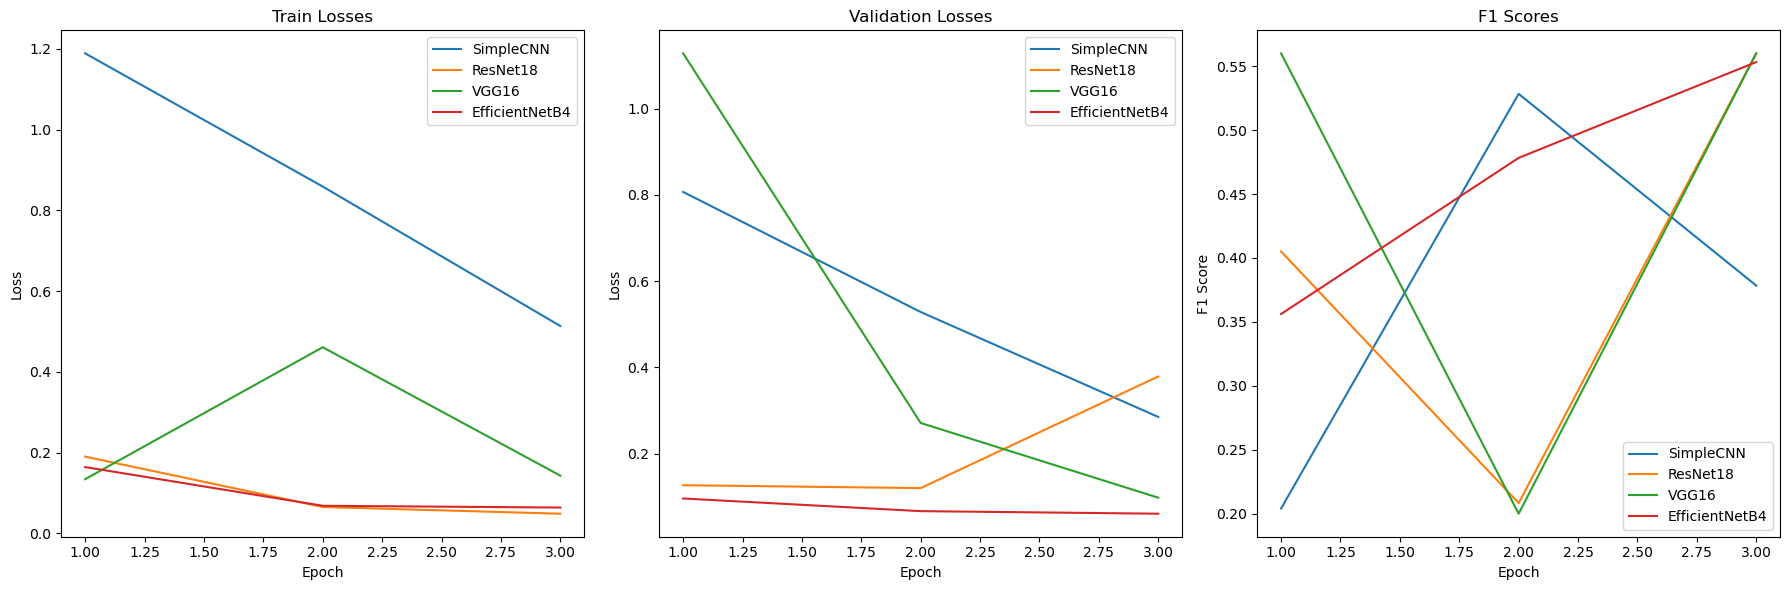

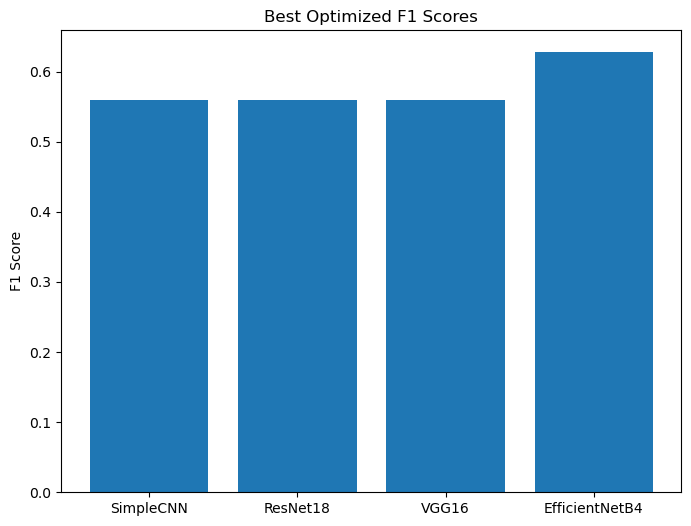

In [9]:
# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# Device Setup and Utility Functions
def get_device():
    if torch.cuda.is_available():
        print(f"CUDA available: {torch.cuda.get_device_name(0)}")
        return torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device("mps")
    print("MPS and CUDA not available, falling back to CPU")
    return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

# Clear GPU memory if using CUDA
if device.type == "cuda":
    torch.cuda.empty_cache()

# Focal Loss with Label Smoothing
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean', label_smoothing=0.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        if self.label_smoothing > 0:
            targets = targets * (1 - self.label_smoothing) + self.label_smoothing / inputs.size(-1)
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        if self.reduction == 'mean':
            return F_loss.mean()
        elif self.reduction == 'sum':
            return F_loss.sum()
        return F_loss

# SimpleCNN Model (Example Architecture)
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=18):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# DataPreprocessor Class
class DataPreprocessor:
    def __init__(self, train_csv='train_cleaned.csv', data_folder='data', img_size=(224, 224)):
        self.train_csv = train_csv
        self.data_folder = data_folder
        self.img_size = img_size
        self.binarizer = MultiLabelBinarizer(classes=list(range(1, 12)) + list(range(13, 20)))
        self.transforms = v2.Compose([
            v2.RandomResizedCrop(size=(224, 224), antialias=True),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(20),
            v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
            v2.RandomErasing(p=0.3, scale=(0.02, 0.2)),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def validate_file(self, file_path: str) -> bool:
        if not os.path.exists(file_path):
            print(f"Error: File not found: {file_path}")
            return False
        if not file_path.endswith('.csv'):
            print(f"Error: File is not a CSV: {file_path}")
            return False
        return True

    def load_and_preprocess_data(self) -> tuple[list, list, np.ndarray]:
        if not self.validate_file(self.train_csv):
            return [], [], np.array([])
        if not os.path.exists(self.data_folder):
            print(f"Error: {self.data_folder} folder not found")
            return [], [], np.array([])

        image_paths, texts, train_labels = [], [], []
        with open(self.train_csv, newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            header = next(reader)
            for row in reader:
                if len(row) >= 3:
                    image_id = row[0]
                    image_path = os.path.join(self.data_folder, image_id)
                    if not os.path.exists(image_path):
                        print(f"Warning: Image {image_path} not found")
                        continue
                    image_paths.append(image_path)
                    texts.append(row[2])
                    label_str = row[1].strip()
                    labels = [label.strip() for label in label_str.split(' ')]
                    try:
                        valid_labels = [int(label) for label in labels if label and int(label) != 12 and 1 <= int(label) <= 19]
                        train_labels.append(valid_labels)
                    except ValueError as e:
                        print(f"Error processing labels in row {row}: {e}")
                        continue

        label_onehot = self.binarizer.fit_transform(train_labels) if len(train_labels) > 0 else np.array([])
        print(f"Loaded paths for {len(image_paths)} training images")
        print(f"Extracted {len(texts)} captions")
        print(f"Shape of label_onehot: {label_onehot.shape}")
        return image_paths, texts, label_onehot

    def preprocess_and_visualize(self) -> tuple[np.ndarray, list, np.ndarray]:
        print("Loading and preprocessing data...")
        image_paths, texts, label_onehot = self.load_and_preprocess_data()
        print("\nVisualizing first image transformations...")
        return image_paths, texts, label_onehot

# CustomDataset Class
class CustomDataset(Dataset):
    def __init__(self, indices, image_paths, label_onehot, transforms):
        self.indices = indices
        self.image_paths = image_paths
        self.label_onehot = label_onehot
        self.transforms = transforms

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_idx = self.indices[idx]
        img_path = self.image_paths[img_idx]
        img = Image.open(img_path).convert('RGB')
        img = torch.from_numpy(np.array(img)).permute(2, 0, 1).to(torch.uint8)
        img = tv_tensors.Image(img)
        img = self.transforms(img)

        label = torch.tensor(self.label_onehot[img_idx], dtype=torch.float32)
        return img, label

# ModelComparison Class
class ModelComparison:
    def __init__(self, train_csv='train_cleaned.csv', data_folder='data', img_size=(224, 224),
                 batch_size=32, train_split=0.8, num_classes=18, lr=0.001, num_epochs=3, max_images=100, device=get_device()):
        self.train_csv = train_csv
        self.data_folder = data_folder
        self.img_size = img_size
        self.batch_size = batch_size
        self.train_split = train_split
        self.num_classes = num_classes
        self.lr = lr
        self.num_epochs = num_epochs
        self.max_images = max_images
        self.device = device
        self.binarizer = MultiLabelBinarizer(classes=list(range(1, 12)) + list(range(13, 20)))
        self.transforms = v2.Compose([
            v2.RandomResizedCrop(size=(224, 224), antialias=True),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(20),
            v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
            v2.RandomErasing(p=0.3, scale=(0.02, 0.2)),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.test_transforms = v2.Compose([
            v2.Resize(size=(224, 224), antialias=True),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.train_loader = None
        self.val_loader = None
        self.image_paths = None

    def validate_file(self, file_path: str) -> bool:
        if not os.path.exists(file_path):
            print(f"Error: File not found: {file_path}")
            return False
        if not file_path.endswith('.csv'):
            print(f"Error: File is not a CSV: {file_path}")
            return False
        return True

    def load_and_preprocess_data(self) -> tuple[list, list, list]:
        if not self.validate_file(self.train_csv) or not os.path.exists(self.data_folder):
            print(f"Error: {self.data_folder} folder not found")
            return [], [], []

        image_paths, texts, train_labels = [], [], []
        image_count = 0

        with open(self.train_csv, newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            try:
                header = next(reader)
            except StopIteration:
                print(f"Error: {self.train_csv} is empty")
                return [], [], []
            for row in reader:
                if image_count >= self.max_images:
                    break
                if len(row) >= 3:
                    image_id = row[0]
                    image_path = os.path.join(self.data_folder, image_id)
                    if not os.path.exists(image_path):
                        print(f"Warning: Image {image_path} not found")
                        continue
                    image_paths.append(image_path)
                    texts.append(row[2])
                    label_str = row[1].strip()
                    labels = [label.strip() for label in label_str.split(' ')]
                    try:
                        valid_labels = [int(label) for label in labels if label and int(label) != 12 and 1 <= int(label) <= 19]
                        train_labels.append(valid_labels)
                    except ValueError as e:
                        print(f"Error processing labels in row {row}: {e}")
                        continue
                    image_count += 1

        print(f"Loaded {image_count} training images")
        return image_paths, texts, train_labels

    def create_dataloaders(self) -> None:
        """Create train and validation DataLoaders with 80/20 split."""
        self.image_paths, texts, train_labels = self.load_and_preprocess_data()
        if not self.image_paths:
            print("No data loaded, cannot create DataLoaders")
            return

        label_onehot = self.binarizer.fit_transform(train_labels) if len(train_labels) > 0 else np.array([])
        dataset_size = len(self.image_paths)
        indices = list(range(dataset_size))
        split = int(self.train_split * dataset_size)
        np.random.seed(42)
        np.random.shuffle(indices)
        train_indices, val_indices = indices[:split], indices[split:]

        train_dataset = CustomDataset(train_indices, self.image_paths, label_onehot, self.transforms)
        val_dataset = CustomDataset(val_indices, self.image_paths, label_onehot, self.test_transforms)

        pin_memory = False if self.device.type == "mps" else True

        self.train_loader = DataLoader(
            train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0, pin_memory=pin_memory
        )
        self.val_loader = DataLoader(
            val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0, pin_memory=pin_memory
        )
        print(f"Created train DataLoader with {len(train_dataset)} samples")
        print(f"Created validation DataLoader with {len(val_dataset)} samples")

    def optimize_threshold(self, outputs, labels):
        """Find the best threshold for F1 score on validation data."""
        thresholds = np.arange(0.1, 0.91, 0.01)
        best_threshold, best_f1 = 0.4, 0.0
        # Convert tensors to float32 before converting to numpy to handle BFloat16/float16
        outputs = torch.sigmoid(outputs).float().cpu().numpy()
        labels = labels.float().cpu().numpy()
        for thresh in thresholds:
            preds = (outputs > thresh).astype(int)
            f1 = torchmetrics.functional.f1_score(
                torch.tensor(preds), torch.tensor(labels), task="multilabel", num_labels=self.num_classes
            ).item()
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = thresh
        print(f"Best Threshold: {best_threshold:.2f}, F1: {best_f1:.4f}")
        return best_threshold, best_f1

    def train_model(self, model, model_name):
        print(f"Training {model_name}...")
        model = model.to(self.device)
        criterion = FocalLoss(alpha=1, gamma=2, label_smoothing=0.1)
        optimizer = torch.optim.AdamW(model.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)
        f1_metric = torchmetrics.F1Score(task="multilabel", num_labels=self.num_classes).to(self.device)

        train_losses, val_losses, f1_scores = [], [], []
        best_f1 = 0.0
        patience = 3
        patience_counter = 0
        best_threshold = 0.4
        best_thresh_f1 = 0.0

        autocast_device = "cuda" if self.device.type == "cuda" else "cpu"
        scaler = torch.amp.GradScaler() if self.device.type == "cuda" else None

        for epoch in range(self.num_epochs):
            model.train()
            total_train_loss = 0
            for images, labels in tqdm(self.train_loader, desc=f"{model_name} Epoch {epoch+1} Training"):
                images, labels = images.to(self.device), labels.to(self.device)
                with torch.amp.autocast(device_type=autocast_device):
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                if scaler:
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    loss.backward()
                    optimizer.step()
                optimizer.zero_grad()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(self.train_loader)
            train_losses.append(avg_train_loss)

            model.eval()
            total_val_loss = 0
            f1_score = 0
            all_outputs, all_labels = [], []
            with torch.no_grad():
                for images, labels in tqdm(self.val_loader, desc=f"{model_name} Epoch {epoch+1} Validation"):
                    images, labels = images.to(self.device), labels.to(self.device)
                    with torch.amp.autocast(device_type=autocast_device):
                        outputs = model(images)
                        loss = criterion(outputs, labels)
                    total_val_loss += loss.item()
                    f1_score += f1_metric(outputs, labels).item()
                    all_outputs.append(outputs)
                    all_labels.append(labels)

            avg_val_loss = total_val_loss / len(self.val_loader)
            mean_f1_score = f1_score / len(self.val_loader)
            val_losses.append(avg_val_loss)
            f1_scores.append(mean_f1_score)

            all_outputs = torch.cat(all_outputs)
            all_labels = torch.cat(all_labels)
            thresh, thresh_f1 = self.optimize_threshold(all_outputs, all_labels)
            if thresh_f1 > best_thresh_f1:
                best_threshold = thresh
                best_thresh_f1 = thresh_f1

            print(f'{model_name} Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, '
                  f'Validation Loss: {avg_val_loss:.4f}, F1 Score: {mean_f1_score:.4f}, '
                  f'Best Threshold: {thresh:.2f}, Threshold F1: {thresh_f1:.4f}')

            scheduler.step(avg_val_loss)

            if mean_f1_score > best_f1:
                best_f1 = mean_f1_score
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping triggered after epoch {epoch+1}")
                    break

            if self.device.type == "cuda":
                torch.cuda.empty_cache()

        return train_losses, val_losses, f1_scores, best_threshold, best_thresh_f1

    def run_comparison(self):
        self.create_dataloaders()
        if self.train_loader is None or self.val_loader is None:
            print("Error: DataLoaders not created, exiting pipeline")
            return

        # Define models and adjust their final layers for the correct number of classes
        models_to_compare = [
            ("SimpleCNN", SimpleCNN(num_classes=self.num_classes)),
            ("ResNet18", models.resnet18(pretrained=True)),
            ("VGG16", models.vgg16(pretrained=True)),
            ("EfficientNetB4", timm.create_model('efficientnet_b4', pretrained=True, num_classes=self.num_classes)),
        ]

        # Adjust final layers of pretrained models
        results = {}
        for model_name, model in models_to_compare:
            if model_name == "ResNet18":
                # ResNet18: Replace the fc layer
                in_features = model.fc.in_features
                model.fc = nn.Linear(in_features, self.num_classes)
            elif model_name == "VGG16":
                # VGG16: Replace the last layer of the classifier
                in_features = model.classifier[-1].in_features
                model.classifier[-1] = nn.Linear(in_features, self.num_classes)

            train_losses, val_losses, f1_scores, best_threshold, best_thresh_f1 = self.train_model(model, model_name)
            results[model_name] = (train_losses, val_losses, f1_scores, best_threshold, best_thresh_f1)

        # Visualize the comparison
        plt.figure(figsize=(18, 6))

        # Train Losses
        plt.subplot(1, 3, 1)
        for name, (tl, _, _, _, _) in results.items():
            plt.plot(range(1, len(tl) + 1), tl, label=name)
        plt.title('Train Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Validation Losses
        plt.subplot(1, 3, 2)
        for name, (_, vl, _, _, _) in results.items():
            plt.plot(range(1, len(vl) + 1), vl, label=name)
        plt.title('Validation Losses')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # F1 Scores
        plt.subplot(1, 3, 3)
        for name, (_, _, fs, _, _) in results.items():
            plt.plot(range(1, len(fs) + 1), fs, label=name)
        plt.title('F1 Scores')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Bar chart for best optimized F1
        plt.figure(figsize=(8, 6))
        model_names = list(results.keys())
        best_f1s = [data[4] for data in results.values()]
        plt.bar(model_names, best_f1s)
        plt.title('Best Optimized F1 Scores')
        plt.ylabel('F1 Score')
        plt.show()

        if self.device.type == "cuda":
            torch.cuda.empty_cache()

# Run the Comparison
if __name__ == "__main__":
    if device.type == "cuda":
        torch.cuda.empty_cache()
    comparison = ModelComparison(device=device)
    comparison.run_comparison()

# Final Model with Captions and Predictions (EffecientNet B4 + Two letter encoder)


Using device: mps
Loading and preprocessing data...
Loaded 30000 training images, 30000 captions

Visualizing first image transformations...


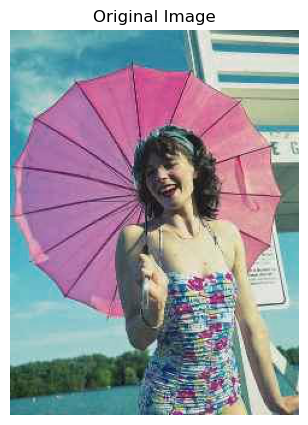

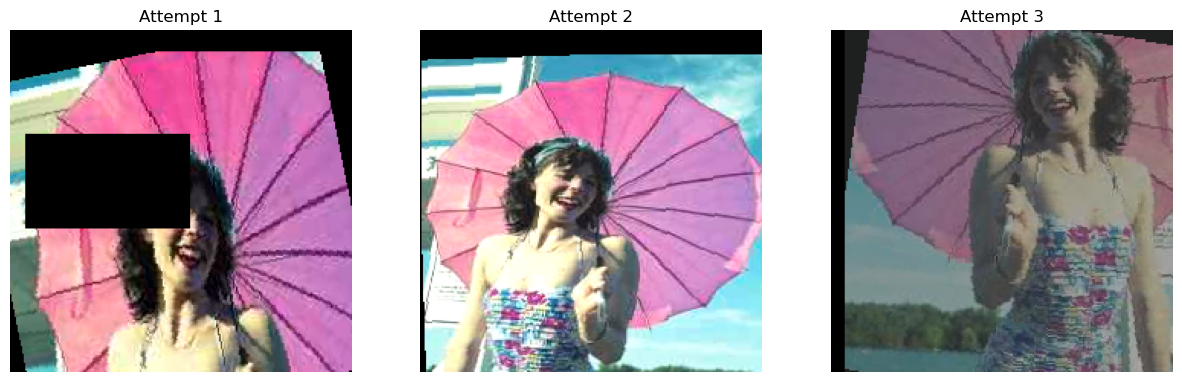

Loaded 100 training images
Created train DataLoader with 80 samples
Created validation DataLoader with 20 samples
Initialized EfficientNet-B4 with captions
EfficientNetWithCaptions - Total Parameters: 18,821,978, Size: 71.80 MB


Epoch 1 Validation: 100%|██████████| 1/1 [00:00<00:00,  8.75it/s]


Epoch 1, Train Loss: 0.1751, Val Loss: 0.1368, F1 Score: 0.5882
Model saved to models/efficientnet_b4_timm_final_epoch1.pth
File models/efficientnet_b4_timm_final_epoch1.pth - Size: 72.54 MB


Epoch 2 Validation: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s]


Epoch 2, Train Loss: 0.1408, Val Loss: 0.0967, F1 Score: 0.5600


Epoch 3 Validation: 100%|██████████| 1/1 [00:00<00:00,  8.92it/s]


Epoch 3, Train Loss: 0.0969, Val Loss: 0.0632, F1 Score: 0.5600


Epoch 4 Validation: 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


Epoch 4, Train Loss: 0.0603, Val Loss: 0.0508, F1 Score: 0.5600
Early stopping at epoch 4


Inference: 100%|██████████| 313/313 [00:52<00:00,  6.00it/s]


Saved predictions to submission.csv


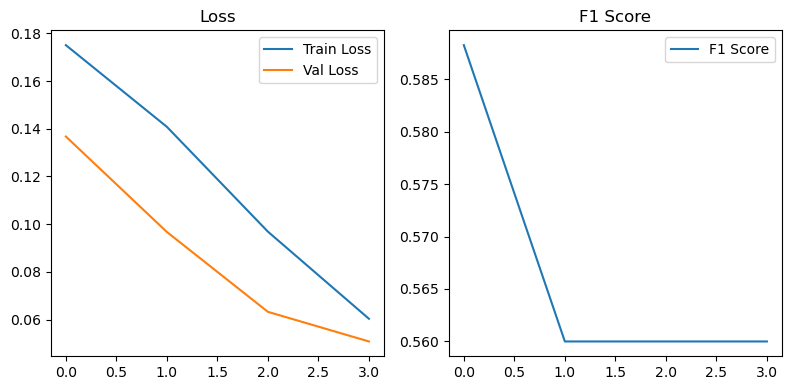

In [10]:
# Constants
CONFIG = {
    "train_cleaned_csv": "train_cleaned.csv",
    "test_cleaned_csv": "test_cleaned.csv",
    "data_dir": "data",
    "training_plot": "training_metrics.png",
    "seed": 42,
    "img_size": (224, 224),
    "batch_size": 32,
    "max_images": 100,
    "num_epochs": 10,
    "learning_rate": 0.001,
    "num_classes": 18,
    "model_save_path": "models/efficientnet_b4_timm_final.pth",
    "accum_steps": 4,
}

# Set random seeds for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Device Setup and Utility Functions
def get_device():
    if torch.cuda.is_available():
        print(f"CUDA available: {torch.cuda.get_device_name(0)}")
        return torch.device("cuda")
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        return torch.device("mps")
    print("MPS and CUDA not available, falling back to CPU")
    return torch.device("cpu")

# Function to calculate model size
def get_model_size(model, model_name="Model"):
    total_params = sum(p.numel() for p in model.parameters())
    size_bytes = total_params * 4
    size_mb = size_bytes / (1024 * 1024)
    print(f"{model_name} - Total Parameters: {total_params:,}, Size: {size_mb:.2f} MB")
    return total_params, size_mb

def get_file_size(file_path):
    if not os.path.exists(file_path):
        print(f"File not found: {file_path}")
        return 0
    size_bytes = os.path.getsize(file_path)
    size_mb = size_bytes / (1024 * 1024)
    print(f"File {file_path} - Size: {size_mb:.2f} MB")
    return size_mb

# Generate mapping dictionary for 2-letter combinations
alphabet_combinations = {'1': string.ascii_lowercase, '2': string.ascii_lowercase}
alphabet_mapping = {}
array_index = 0

for combo in itertools.product(*[alphabet_combinations[k] for k in sorted(alphabet_combinations.keys())]):
    letter_combinations = ''.join(combo)
    alphabet_mapping[letter_combinations] = array_index
    array_index += 1

def encode_captions(captions):
    '''
    Transforms a list/tuple of N captions into a N x NUM_LABELS size Torch tensor using 2-letter combinations.
    '''
    word_encoding_array = np.zeros((len(captions), len(alphabet_mapping)), dtype=np.float32)
    for caption_num, caption in enumerate(captions):
        split_text = [x for x in caption.lower() if x in string.ascii_lowercase]
        for idx in range(len(split_text)):
            if idx + 2 > len(split_text):
                break
            combination = ''.join(split_text[idx:idx + 2])
            if combination in alphabet_mapping:
                array_idx = alphabet_mapping[combination]
                word_encoding_array[caption_num][array_idx] += 1
    word_encoding_array = torch.from_numpy(word_encoding_array).float()
    return word_encoding_array

# Focal Loss
class FocalLoss(nn.Module):
    """Focal loss for multi-label classification."""
    def __init__(self, alpha=1, gamma=2, reduction='mean', label_smoothing=0.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        if self.label_smoothing > 0:
            targets = targets * (1 - self.label_smoothing) + self.label_smoothing / inputs.size(-1)
        BCE_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        return F_loss.mean() if self.reduction == 'mean' else F_loss.sum()

# Data Preprocessor
class DataPreprocessor:
    """Preprocess data and visualize transformations."""
    def __init__(self, train_csv=CONFIG["train_cleaned_csv"], data_folder=CONFIG["data_dir"], img_size=CONFIG["img_size"]):
        self.train_csv = train_csv
        self.data_folder = data_folder
        self.img_size = img_size
        self.binarizer = MultiLabelBinarizer(classes=list(range(1, 12)) + list(range(13, 20)))
        self.transforms = v2.Compose([
            v2.RandomResizedCrop(size=(224, 224), antialias=True),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(20),
            v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
            v2.RandomErasing(p=0.3, scale=(0.02, 0.2)),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def validate_file(self, file_path: str) -> bool:
        """Validate CSV file."""
        if not os.path.exists(file_path):
            print(f"Error: File not found: {file_path}")
            return False
        if not file_path.endswith('.csv'):
            print(f"Error: File is not a CSV: {file_path}")
            return False
        return True

    def load_and_preprocess_data(self) -> tuple[list, list, np.ndarray]:
        """Load and preprocess training data."""
        if not self.validate_file(self.train_csv) or not os.path.exists(self.data_folder):
            return [], [], np.array([])

        image_paths, texts, train_labels = [], [], []
        with open(self.train_csv, newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                if len(row) >= 3:
                    image_id = row[0]
                    image_path = os.path.join(self.data_folder, image_id)
                    if not os.path.exists(image_path):
                        print(f"Warning: Image {image_path} not found")
                        continue
                    image_paths.append(image_path)
                    texts.append(row[2])
                    labels = [int(label) for label in row[1].split() if label and int(label) != 12 and 1 <= int(label) <= 19]
                    train_labels.append(labels)

        label_onehot = self.binarizer.fit_transform(train_labels) if len(train_labels) > 0 else np.array([])
        print(f"Loaded {len(image_paths)} training images, {len(texts)} captions")
        return image_paths, texts, label_onehot

    def visualize_first_image_transforms(self, num_attempts: int = 3) -> None:
        """Visualize transformations on the first image."""
        with open(self.train_csv, newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            next(reader)
            row = next(reader)
            image_id = row[0]
            image_path = os.path.join(self.data_folder, image_id)
            if not os.path.exists(image_path):
                print(f"Image not found: {image_path}")
                return

        img_pil = Image.open(image_path).convert('RGB')
        img = torch.from_numpy(np.array(img_pil)).permute(2, 0, 1).to(torch.uint8)
        img = tv_tensors.Image(img)

        plt.figure(figsize=(5, 5))
        plt.imshow(img_pil)
        plt.title("Original Image")
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(15, 5))
        for i in range(num_attempts):
            img_transformed = self.transforms(img)
            img_display = img_transformed * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
            img_display = img_display.clamp(0, 1).permute(1, 2, 0).numpy()
            plt.subplot(1, num_attempts, i + 1)
            plt.imshow(img_display)
            plt.title(f"Attempt {i+1}")
            plt.axis('off')
        plt.show()

    def preprocess_and_visualize(self) -> tuple[np.ndarray, list, np.ndarray]:
        """Run preprocessing and visualization."""
        print("Loading and preprocessing data...")
        image_paths, texts, label_onehot = self.load_and_preprocess_data()
        print("\nVisualizing first image transformations...")
        self.visualize_first_image_transforms()
        return image_paths, texts, label_onehot

# Custom Datasets
class CustomDataset(Dataset):
    """Dataset for training with images, captions, and labels."""
    def __init__(self, indices, image_paths, texts, label_onehot, transforms):
        self.indices = indices
        self.image_paths = image_paths
        self.texts = texts
        self.label_onehot = label_onehot
        self.transforms = transforms

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_idx = self.indices[idx]
        img = Image.open(self.image_paths[img_idx]).convert('RGB')
        img = torch.from_numpy(np.array(img)).permute(2, 0, 1).to(torch.uint8)
        img = tv_tensors.Image(img)
        img = self.transforms(img)
        caption = self.texts[img_idx]
        label = torch.tensor(self.label_onehot[img_idx], dtype=torch.float32)
        return img, caption, label

class TestDataset(Dataset):
    """Dataset for test set predictions."""
    def __init__(self, image_ids, image_paths, texts, transforms):
        self.image_ids = image_ids
        self.image_paths = image_paths
        self.texts = texts
        self.transforms = transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx]).convert('RGB')
        img = torch.from_numpy(np.array(img)).permute(2, 0, 1).to(torch.uint8)
        img = tv_tensors.Image(img)
        img = self.transforms(img)
        return self.image_ids[idx], img, self.texts[idx]

# Model
class EfficientNetWithCaptions(nn.Module):
    """EfficientNet-B4 with caption features."""
    def __init__(self, num_classes=CONFIG["num_classes"]):
        super().__init__()
        self.efficientnet = timm.create_model('efficientnet_b4', pretrained=True, num_classes=0)
        self.image_feature_dim = 1792
        self.caption_feature_dim = len(alphabet_mapping)
        self.fusion = nn.Linear(self.image_feature_dim + self.caption_feature_dim, 512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, images, caption_features):
        image_features = self.efficientnet(images)
        combined_features = torch.cat((image_features, caption_features), dim=1)
        x = self.fusion(combined_features)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

# Classifier
class MultiLabelClassifier:
    """Train and validate the final model."""
    def __init__(self, device=get_device()):
        self.train_csv = CONFIG["train_cleaned_csv"]
        self.data_folder = CONFIG["data_dir"]
        self.batch_size = CONFIG["batch_size"]
        self.max_images = CONFIG["max_images"]
        self.num_epochs = CONFIG["num_epochs"]
        self.lr = CONFIG["learning_rate"]
        self.device = device
        self.num_classes = CONFIG["num_classes"]
        self.model_save_path = CONFIG["model_save_path"]
        self.accum_steps = CONFIG["accum_steps"]
        self.binarizer = MultiLabelBinarizer(classes=list(range(1, 12)) + list(range(13, 20)))
        self.transforms = v2.Compose([
            v2.RandomResizedCrop(size=(224, 224), antialias=True),
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(20),
            v2.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2)),
            v2.RandomErasing(p=0.3, scale=(0.02, 0.2)),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.test_transforms = v2.Compose([
            v2.Resize(size=(224, 224), antialias=True),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        self.model = None
        self.train_loader = None
        self.val_loader = None

    def validate_file(self, file_path: str) -> bool:
        """Validate CSV file."""
        if not os.path.exists(file_path):
            print(f"Error: File not found: {file_path}")
            return False
        if not file_path.endswith('.csv'):
            print(f"Error: File is not a CSV: {file_path}")
            return False
        return True

    def load_and_preprocess_data(self) -> tuple[list, list, list]:
        """Load training data."""
        if not self.validate_file(self.train_csv) or not os.path.exists(self.data_folder):
            return [], [], []

        image_paths, texts, train_labels = [], [], []
        image_count = 0
        with open(self.train_csv, newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                if image_count >= self.max_images:
                    break
                if len(row) >= 3:
                    image_id = row[0]
                    image_path = os.path.join(self.data_folder, image_id)
                    if not os.path.exists(image_path):
                        print(f"Warning: Image {image_path} not found")
                        continue
                    image_paths.append(image_path)
                    texts.append(row[2])
                    labels = [int(label) for label in row[1].split() if label and int(label) != 12 and 1 <= int(label) <= 19]
                    train_labels.append(labels)
                    image_count += 1

        print(f"Loaded {len(image_paths)} training images")
        return image_paths, texts, train_labels

    def create_dataloaders(self) -> None:
        """Create train and validation DataLoaders."""
        image_paths, texts, train_labels = self.load_and_preprocess_data()
        if not image_paths:
            return

        label_onehot = self.binarizer.fit_transform(train_labels) if len(train_labels) > 0 else np.array([])
        indices = list(range(len(image_paths)))
        split = int(0.8 * len(image_paths))
        np.random.seed(CONFIG["seed"])
        np.random.shuffle(indices)
        train_indices, val_indices = indices[:split], indices[split:]

        train_dataset = CustomDataset(train_indices, image_paths, texts, label_onehot, self.transforms)
        val_dataset = CustomDataset(val_indices, image_paths, texts, label_onehot, self.test_transforms)

        pin_memory = False if self.device.type == "mps" else True
        self.train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=0, pin_memory=pin_memory)
        self.val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0, pin_memory=pin_memory)
        print(f"Created train DataLoader with {len(train_dataset)} samples")
        print(f"Created validation DataLoader with {len(val_dataset)} samples")

    def setup_model(self) -> None:
        """Initialize model and training components."""
        self.model = EfficientNetWithCaptions(num_classes=self.num_classes).to(self.device)
        print(f"Initialized EfficientNet-B4 with captions")
        get_model_size(self.model, "EfficientNetWithCaptions")
        self.criterion = FocalLoss(alpha=1, gamma=2, label_smoothing=0.1)
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=2)
        self.f1 = torchmetrics.F1Score(task="multilabel", num_labels=self.num_classes).to(self.device)

    def optimize_threshold(self, outputs, labels):
        """Find optimal threshold for F1 score."""
        thresholds = np.arange(0.1, 0.91, 0.01)
        best_threshold, best_f1 = 0.4, 0.0
        outputs = torch.sigmoid(outputs).float().cpu().numpy()  # Ensure float32 for numpy conversion
        labels = labels.float().cpu().numpy()
        for thresh in thresholds:
            preds = (outputs > thresh).astype(int)
            f1 = torchmetrics.functional.f1_score(
                torch.tensor(preds), torch.tensor(labels), task="multilabel", num_labels=self.num_classes
            ).item()
            if f1 > best_f1:
                best_f1, best_threshold = f1, thresh
        return best_threshold, best_f1

    def train_and_validate(self) -> tuple[list, list, list, float]:
        """Train and validate the model."""
        if not self.model or not self.train_loader or not self.val_loader:
            print("Model or DataLoaders not initialized")
            return [], [], [], 0.4

        train_losses, val_losses, f1_scores = [], [], []
        best_f1, patience, patience_counter = 0.0, 3, 0
        best_threshold = 0.4
        autocast_device = "cuda" if self.device.type == "cuda" else "cpu"
        scaler = torch.amp.GradScaler() if self.device.type == "cuda" else None

        for epoch in range(self.num_epochs):
            self.model.train()
            total_train_loss, accum_loss = 0, 0
            for i, (images, captions, labels) in enumerate(tqdm(self.train_loader, desc=f"Epoch {epoch+1} Training")):
                images, labels = images.to(self.device), labels.to(self.device)
                caption_features = encode_captions(captions).to(self.device)
                with torch.amp.autocast(device_type=autocast_device):
                    outputs = self.model(images, caption_features)
                    loss = self.criterion(outputs, labels) / self.accum_steps
                if scaler:
                    scaler.scale(loss).backward()
                else:
                    loss.backward()
                accum_loss += loss.item()

                if (i + 1) % self.accum_steps == 0:
                    if scaler:
                        scaler.step(self.optimizer)
                        scaler.update()
                    else:
                        self.optimizer.step()
                    self.optimizer.zero_grad()
                    total_train_loss += accum_loss * self.accum_steps
                    accum_loss = 0

            if accum_loss > 0:
                if scaler:
                    scaler.step(self.optimizer)
                    scaler.update()
                else:
                    self.optimizer.step()
                self.optimizer.zero_grad()
                total_train_loss += accum_loss * self.accum_steps

            avg_train_loss = total_train_loss / len(self.train_loader)
            train_losses.append(avg_train_loss)

            self.model.eval()
            total_val_loss, f1_score = 0, 0
            all_outputs, all_labels = [], []
            with torch.no_grad():
                for images, captions, labels in tqdm(self.val_loader, desc=f"Epoch {epoch+1} Validation"):
                    images, labels = images.to(self.device), labels.to(self.device)
                    caption_features = encode_captions(captions).to(self.device)
                    with torch.amp.autocast(device_type=autocast_device):
                        outputs = self.model(images, caption_features)
                        loss = self.criterion(outputs, labels)
                    total_val_loss += loss.item()
                    f1_score += self.f1(outputs, labels).item()
                    all_outputs.append(outputs)
                    all_labels.append(labels)

            avg_val_loss = total_val_loss / len(self.val_loader)
            mean_f1_score = f1_score / len(self.val_loader)
            val_losses.append(avg_val_loss)
            f1_scores.append(mean_f1_score)

            all_outputs = torch.cat(all_outputs)
            all_labels = torch.cat(all_labels)
            best_threshold, thresh_f1 = self.optimize_threshold(all_outputs, all_labels)

            print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, '
                  f'Val Loss: {avg_val_loss:.4f}, F1 Score: {mean_f1_score:.4f}')

            self.scheduler.step(avg_val_loss)
            if mean_f1_score > best_f1:
                best_f1 = mean_f1_score
                patience_counter = 0
                self.save_model(epoch=epoch)
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

            if self.device.type == "cuda":
                torch.cuda.empty_cache()
            elif self.device.type == "mps":
                torch.mps.empty_cache()

        return train_losses, val_losses, f1_scores, best_threshold

    def save_model(self, epoch=None) -> None:
        """Save model state."""
        save_path = self.model_save_path if epoch is None else f"{self.model_save_path.replace('.pth', f'_epoch{epoch+1}.pth')}"
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        torch.save(self.model.state_dict(), save_path)
        print(f"Model saved to {save_path}")
        get_file_size(save_path)

# Predictor
class MultiLabelPredictor:
    """Generate predictions on test set."""
    def __init__(self, model, binarizer, device=get_device(), threshold=0.4):
        self.model = model
        self.binarizer = binarizer
        self.data_folder = CONFIG["data_dir"]
        self.batch_size = CONFIG["batch_size"]
        self.device = device
        self.threshold = threshold
        self.transforms = v2.Compose([
            v2.Resize(size=(224, 224), antialias=True),
            v2.ToDtype(torch.float32, scale=True),
            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    def validate_file(self, file_path: str) -> bool:
        """Validate CSV file."""
        if not os.path.exists(file_path):
            print(f"Error: File not found: {file_path}")
            return False
        if not file_path.endswith('.csv'):
            print(f"Error: File is not a CSV: {file_path}")
            return False
        return True

    def predict_test_set(self, test_csv=CONFIG["test_cleaned_csv"]):
        """Predict labels for test set."""
        if not self.model:
            print("Error: Model not initialized")
            return
        if not self.validate_file(test_csv):
            return

        image_ids, image_paths, texts = [], [], []
        with open(test_csv, newline='', encoding='utf-8') as file:
            reader = csv.reader(file)
            next(reader)
            for row in reader:
                if len(row) >= 1:
                    image_id = row[0]
                    image_path = os.path.join(self.data_folder, image_id)
                    if not os.path.exists(image_path):
                        print(f"Warning: Image {image_path} not found")
                        continue
                    image_ids.append(image_id)
                    image_paths.append(image_path)
                    texts.append(row[1] if len(row) > 1 else "")

        if not image_paths:
            print("No test images loaded")
            return

        test_dataset = TestDataset(image_ids, image_paths, texts, self.transforms)
        pin_memory = False if self.device.type == "mps" else True
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=0, pin_memory=pin_memory)

        self.model.eval()
        predictions, pred_image_ids = [], []
        autocast_device = "cuda" if self.device.type == "cuda" else "cpu"
        with torch.no_grad():
            for image_ids_batch, images, captions in tqdm(test_loader, desc="Inference"):
                images = images.to(self.device)
                caption_features = encode_captions(captions).to(self.device)
                with torch.amp.autocast(device_type=autocast_device):
                    outputs = self.model(images, caption_features)
                preds = (torch.sigmoid(outputs).float().cpu().numpy() > self.threshold).astype(int)
                predictions.extend(preds)
                pred_image_ids.extend(image_ids_batch)

        label_strings = [' '.join(str(cls) for i, cls in enumerate(self.binarizer.classes_) if pred[i]) or '' for pred in predictions]
        submission = pd.DataFrame({'ImageID': pred_image_ids, 'Labels': label_strings})
        submission.to_csv('submission.csv', index=False)
        print("Saved predictions to submission.csv")

# Main Execution
if __name__ == "__main__":
    set_seed(CONFIG["seed"])
    device = get_device()
    print(f"Using device: {device}")
    if device.type == "cpu":
        print("WARNING: GPU not detected. Using CPU.")
    if device.type == "cuda":
        torch.cuda.empty_cache()
    elif device.type == "mps":
        torch.mps.empty_cache()

    preprocessor = DataPreprocessor()
    image_paths, texts, label_onehot = preprocessor.preprocess_and_visualize()

    classifier = MultiLabelClassifier(device=device)
    classifier.create_dataloaders()
    classifier.setup_model()
    train_losses, val_losses, f1_scores, best_threshold = classifier.train_and_validate()

    predictor = MultiLabelPredictor(model=classifier.model, binarizer=classifier.binarizer, device=device, threshold=best_threshold)
    predictor.predict_test_set()

    # Visualize Training Metrics
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title('Loss')
    plt.legend()
    plt.subplot(1, 3, 2)
    plt.plot(f1_scores, label='F1 Score')
    plt.title('F1 Score')
    plt.legend()
    plt.tight_layout()
    plt.show()